<h1 style = "font-size: 35px; text-align: center;">AI Final project</h1>
<h1 style = "font-size: 35px; text-align: center;">Regression machine learning</h1>
<h1 style = "font-size: 32px; text-align: center; color: #666">Taha Shabani 810196491</h1>

<br>
<h1 style = "text-align: center">Introduction</h1>
<br>
<h2>Definition of project:</h2>
<p style = "font-size: 14px">In this project we face a regression problem and try to solve it using methods we've learned during this course about <b>machine learning, training, networks, preprocessing, tuning and etc</b> : </p>
<br>
<p><mark>Phase 1 :</mark> we read dataset from <b>mobile_phone_dataset.csv</b> using <b>pandas dataframe</b> and perform some preprocessings on columns <b>except for two columns</b> : title, desc. main tasks : </p>
<p style="text-indent :2em;">1.1. onehot encoding for categorical columns</p>
<p style="text-indent :2em;">1.2. preprocessing of time.</p>
<p style="text-indent :2em;">1.3. correction and preprocessing of price.</p>
<p style="text-indent :2em;">1.4. oversampling for better solutions.</p>
<p style="text-indent :2em;">1.5. showing information gain for current results.</p>
<br>

<p><mark>Phase 2 :</mark> in this part we perform preprocessing for <b>title and desc</b> : </p>
<p style="text-indent :2em;">2.1. lowering all capital letters</p>
<p style="text-indent :2em;">2.2. normalization.</p>
<p style="text-indent :2em;">2.3. removing stop words and non-relative words such as <u>سلام</u> for example.</p>
<p style="text-indent :2em;">2.4. lemmatization.</p>
<p style="text-indent :2em;">2.5. counting repeats per every word in columns (title and desc separately).</p>
<p style="text-indent :2em;">2.6. sort words(useful words) in a descending form based on their repeats.</p>
<br>

<p><mark>Phase 3 :</mark> goal of this phase is to adding top words as new features in our dataset and finally split data into train and test data : </p>
<p style="text-indent :2em;">3.1. choosing top words</p>
<p style="text-indent :2em;">3.2. adding top words as features (done for both columns: title and desc).</p>
<p style="text-indent :2em;">3.3. preparing data and target_data (prices) for splitting.</p>
<p style="text-indent :2em;">3.4. preparing test and train data.</p>
<br>

<p><mark>Phase 4 :</mark> we test our data over multiple regression models and try to improve performance : </p>
<p style="text-indent :2em;">4.1. linear regression</p>
<p style="text-indent :2em;">4.2. random forest regression</p>
<p style="text-indent :2em;">4.3. ridge regression</p>
<p style="text-indent :2em;">4.4. svr regression.</p>
<p style="text-indent :2em;">4.5. light gbm regression.</p>
<br>

<p><mark>Phase 5 :</mark>exports and conclusion.</p>







In [1]:
import csv
import pandas as pd
import math
import numpy as np
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
def showProgressPercentage(current, total) : 
    prevPercentage = int ((current-1) / total * 100)
    currPrecentage = int (current / total * 100)
    progress = 0
    if (currPrecentage >= 90 and prevPercentage < 90) : 
        progress = 90
    elif (currPrecentage >= 80 and prevPercentage < 80) : 
        progress = 80 
    elif (currPrecentage >= 70 and prevPercentage < 70) : 
        progress = 70 
    elif (currPrecentage >= 60 and prevPercentage < 60) : 
        progress = 60 
    elif (currPrecentage >= 50 and prevPercentage < 50) : 
        progress = 50 
    elif (currPrecentage >= 40 and prevPercentage < 40) : 
        progress = 40 
    elif (currPrecentage >= 30 and prevPercentage < 30) : 
        progress = 30 
    elif (currPrecentage >= 20 and prevPercentage < 20) : 
        progress = 20 
    elif (currPrecentage >= 10 and prevPercentage < 10) : 
        progress = 10 
    if (progress > 0) :
        print(progress, "%")
        
def mapDayToNumber(day) :
    dayOfWeeks = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    for i in range(len(dayOfWeeks)) : 
        if (dayOfWeeks[i] == day) : 
            return i+1
    return 0
def mapTimeToNumber(time) :
    times = ["12AM", "01AM", "02AM", "03AM", "04AM", "05AM", "06AM", "07AM", "08AM", "09AM", "10AM", "11AM", "12PM", "01PM", "02PM", "03PM", "04PM", "05PM", "06PM", "07PM", "08PM", "09PM", "10PM", "11PM"]
    for i in range(len(times)) : 
        if (times[i] == time) : 
            return i
    return 0
    
def fetchDay(createTime)  :
    [dayOfWeek, time] = createTime.split(' ')
    return mapDayToNumber(dayOfWeek)

def fetchTime(createTime) : 
    [dayOfWeek, time] = createTime.split(' ')
    return mapTimeToNumber(time)

def correctThePrice(oldPrice) : 
    newPrice = oldPrice
    if (4500 < oldPrice < 10000) : 
        newPrice = -11 #just a number beneath -1 and also -10
    
    elif (10 <= oldPrice <= 4500) : 
        newPrice = oldPrice * 1000
        
    elif (0 < oldPrice < 10) : 
        newPrice = -11
    
    return newPrice

def getAveragePricesPerBrands(df, brands) : 
    sums = { i : 0 for i in brands }
    repeats = { i : 0 for i in brands }
    avgs = { i : 0 for i in brands }
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price != -1) : 
            sums[dfRow['brand']] += price
            repeats[dfRow['brand']] += 1
    for brand in brands : 
        avgs[brand] = int(sums[brand] / repeats[brand])
    return [avgs, repeats]
        
    

<br>

<h1 style= "text-align: center">Phase 1</h1>
<br>
<h3> 1. Preprocessing (except for title and desc): </h3>

<mark>1.1. Onehot encoding for categorical columns</mark>
<p style="text-indent :2em;">For <b>brand</b> and <b>city</b> which are categorical data, we had two choices: <u> one hot encoding and labeled encoding</u> : </p>
<h4 style = "color: red">One hot Encodling vs Labeled encoding</h4>
<p>
    As we mentioned, these encodings are used for categorical data, which in our case is <b>Country</b> column.
    <br>
    <br>
    <b>One Hot</b> adds a column for every different values in categorical column and sets the bit for current value to 1 and 0 for the rest. for example if countries are (USA, Frace, Germany) and if current country is Germany we will have (0,0,1).
    <br>
    On the other side <b>Labeled</b> maps every value to a numeric one, for example (USA -> 1, Frace -> 2, Germany -> 3).
    <br>
    <br>
    <b>One Hot cons</b>: As it's clear, OneHot makes the data too big and adds lots of columns, so operations might get a little slower and overfitting is probable. In these cases we use labeled encoding or some method like scaling and ...
    <br>
    <b>Labeled cons</b>: Label encoding is acceptable for discrete values but not continuous ones, plus, it could trigger some issues for classifers, for example as we said we assigned USA to 1 and Frace to 2, now Frace has a higher value with no reason, and it can be harmful for network accuracy.
    
</p>
<p style="text-indent :2em;">So because columns were not a lot and one hot works better for our model, we decided to use one hot encoding: </p>
<br>

<mark>1.2. preprocessing of time.</mark>
<p style="text-indent :2em;">In this process, we just separate day of week and hour of day and add them as two numbers [1-7] and [0-23] respectively.</p>
<br>

<mark>1.3. correction and preprocessing of price.</mark>
<p style="text-indent :2em;">1.3.1 : we delete prices on invalid ranges for example between [0,10] and etc.</p>
<p style="text-indent :2em;">1.3.2 : we replace -1 prices with average of current category, for instance if we have a -1 for an apple one, we replace -1 with average of all apple prices.</p>

<br>

<mark>1.4. oversampling for better solutions.</mark>
<p style="text-indent :2em;">As we see nokia has least average (about 250000 tomans) price and it's repeats are close to 4000. so we oversampled it for twice of its size (ultimately about 8000 rows) just to improve performance -> <b>mse improves for about 4000 tomans on average.</b></p>
<br>

<mark>1.5. showing information gain for current results.
<p style="text-indent :2em;">We depict information gains using <b>mutual_info_classif()</b>.</p>
<br> 

In [3]:
def getProcessedNonTextData(dataFile, brandEncType = "onehot", cityEncType = "onehot") : 
    data = []
    valData = []
    targetData = []
    col_list = ["brand", "city", "title", "desc", "image_count", "created_at", "price"]
    df = pd.read_csv(dataFile, usecols=col_list)
    
    print("preprocessing started...")
    
    if (brandEncType == "onehot") :
        df = pd.concat([df,pd.get_dummies(df['brand'], prefix = "brand")],axis=1)
    
    print("brand onehot encoding done...")
        
    if (cityEncType == "onehot") :
        df = pd.concat([df,pd.get_dummies(df['city'], prefix = "city")],axis=1)
        
    print("city onehot encoding done...")
    
    df['dayOfweek'] = df.apply(lambda row : fetchDay(row['created_at']), axis = 1) 
    df['time'] = df.apply(lambda row : fetchTime(row['created_at']), axis = 1) 
    del df['created_at']
    
    print("time preprocessing done...")
    
    df['price'] = df.apply(lambda row : correctThePrice(row['price']), axis = 1)
    df = df.loc[df['price'] > -10]
    
    brands = df.brand.unique()
    [avgPrices, rep] = getAveragePricesPerBrands(df, brands)
    
    print("price correction done, average price per every brand calculated...")
    
    nokiaRows = df[df['brand'] == "Nokia::نوکیا"]
    df = df.append(nokiaRows)
    
    print("nokia rows oversampled just to improve performance...")
    
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        targetData.append(price)
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']  
        data.append(dfRow)
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']  
        del dfRow['title']
        del dfRow['desc']
        valData.append(dfRow)
        
    
    labels = list(df)
    labels.remove('price')
    labels.remove('brand')
    labels.remove('city')
    valLabels = list(df)
    valLabels.remove('price')
    valLabels.remove('brand')
    valLabels.remove('city')
    valLabels.remove('title')
    valLabels.remove('desc')
    
    print("part1 done.")
    return [df, data, valData, targetData, labels, valLabels]

In [4]:
[df, data, valData, targetData, labels, valLabels] = getProcessedNonTextData("mobile_phone_dataset.csv")

preprocessing started...
brand onehot encoding done...
city onehot encoding done...
time preprocessing done...
price correction done, average price per every brand calculated...
nokia rows oversampled just to improve performance...
part1 done.


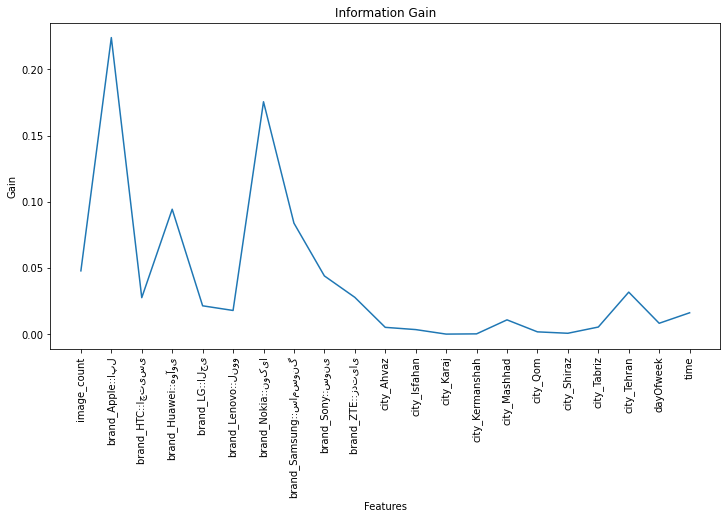

In [5]:
informationGains = mutual_info_classif(valData, targetData)
def showInformationGains(labels) :
    plt.figure(figsize=(12, 6))
    plt.plot(informationGains) 
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.xlabel('Features') 
    plt.ylabel('Gain') 
    plt.title('Information Gain') 

    plt.show()
showInformationGains(valLabels)

<br>

<h1 style= "text-align: center">Phase 2</h1>
<br>
<h3> 2. Preprocessing title and desc using hazm library : </h3>
<p>In this phase we separately do following acts on both title and desc : </p>

<mark>2.1. lowering all capital letters.</mark>
<p style="text-indent :2em;">This process makes for example "ASUS" and "Asus" the same and helps for feature extraction.</p>
<br>

<mark>2.2. normalization.</mark>
<p style="text-indent :2em;">In order to normalize context fo titles and descs.</p>
<br>

<mark>2.3. removing stop words and non-relative words such as سلام for example.</mark>
<p>We generated a set named <b>stop_words</b> and add these words in it : </p>
<p style="text-indent :2em;">2.3.1 : persian stop words <b>(provided by hazm)</b></p>
<p style="text-indent :2em;">2.3.2 : english stop words <b>(provided by nltk)</b></p>
<p style="text-indent :2em;">2.3.3 : irrelative words such as سلام for example</p>
<p style="text-indent :2em;">2.3.4 : punctuations</p>

<br>

<mark>2.4. lemmatization.</mark>
<p style="text-indent :2em;">We had two choices: stemming or lemmatization and for our project lemmatization works better because it replace words with it's base word.</p>
<br>

<mark>2.5. counting repeats per every word in columns (title and desc separately).</mark>
<p style="text-indent :2em;">We count repeats or each word which are not in stop_words separatly for title and desc columns.</p>
<br> 

<mark>2.6. sort words(useful words) in a descending form based on their repeats.</mark>
<p style="text-indent :2em;">In order to choose top words in future as new features.</p>
<br> 

<p><b>NOTE: instead of counting number of repeats we could use tf_idf method for words as features, but due to time limitations, we couldn't test that.</b></p>
<br>

In [6]:
import hazm
from hazm.WordTokenizer import WordTokenizer
from nltk.corpus import stopwords 
from hazm.Lemmatizer import Lemmatizer
from hazm.Normalizer import Normalizer
import operator

stop_words_fa = set(hazm.utils.stopwords_list()) 
stop_words_en = set(stopwords.words('english')) 
punctuations = {",", ".", "(", ")", ";", ":", "؛", "،"}
bulshits = {"معاوضه", "تی", "n", "کارت", "رنگ", "se", "تعویض", "ساده", "لا", "حتما", "پرید#پر", "فروشی", "بخونید", "عدد", "قیمت", "داره", "تخفیف", "هست", "داشت#دار", "سلام", "تماس", "فروش", "میدم", "یه", "نداره", "خریدار", "لطفا", "مقطوع", "شرط", "خرید#خر", "کارتن", "میباشد", "تشکر", "میکنم", "العاده", "عدد", "ممنون", "فوری", "خودم", "عکس", "دی", "-", "معامله", "کارتون", "پیامک", "مشتری", "هستش", "جواب", "هفته", "پای", "جانبی", "میشه", "زنگ", "تومن", "باتشکر", "اصلا", "کرد#کن", "باسلام", "فروخت#فروش", "مگاپیکسل", "میخوام", "مهلت", "میشود", "ب", "یاعلی", "اگه", "گذاشت#گذار", "واقعا", "تومان", "باشه"}
stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(punctuations)
stop_words = stop_words.union(bulshits)

normalizer = Normalizer()
tokenizer = WordTokenizer()
lemmatizer = Lemmatizer()
# print(stop_words)

def lowerAllCharacters(context) :
    context = context.lower()
    return context

def normalizeContext(context) : 
    context = normalizer.affix_spacing(context)
    context = normalizer.character_refinement(context)
    context = normalizer.punctuation_spacing(context)
    return context

def removeStopWordsAndPunctuations(context) : 
#     tokenizer = RegexpTokenizer(r'\w+')
    context = tokenizer.tokenize(context)
    
    filtered_sentence = [] 
    
    for w in context: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def lemmatizeWords(wordList) : 
    for i in range(len(wordList)):
        wordList[i] = lemmatizer.lemmatize(wordList[i])
            
    return wordList

def finalStopCheck(wordList) : 
    filtered_sentence = [] 
    
    for w in wordList: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def getProcessedWords(context) : 
    context = lowerAllCharacters(context)
    context = normalizeContext(context)
#     wordList = []
    wordList = removeStopWordsAndPunctuations(context)
    wordList = lemmatizeWords(wordList)
    wordList = finalStopCheck(wordList)
    return wordList


In [7]:
def getProcessedTextData(data, rowName) : 
    totalWords = {}
    wordLists = []
    for row in data :
        wordList = getProcessedWords(row[rowName])
        wordLists.append(wordList)
        for word in wordList : 
            if word in totalWords : 
                totalWords[word] += 1
            else :
                totalWords[word] = 1
#         print(i)
#         print(row['title'])
#         print(wordList)
#         print("_____________________________________________________")
    return [wordLists, totalWords]

In [11]:
[titleWordLists, totalTitleWords] = getProcessedTextData(data, 'title')

In [12]:
[descWordLists, totalDescWords] = getProcessedTextData(data, 'desc')

In [13]:
sortedTitleWords = sorted(totalTitleWords.items(),key=operator.itemgetter(1),reverse=True)
sortedDescWords = sorted(totalDescWords.items(),key=operator.itemgetter(1),reverse=True)
# print(sortedTitleWords)
# print(sortedDescWords)


In [14]:
handedFeatures = {"آیفون", "ایفون", "apple", "اپل", "iphone", "samsung", "سامسونگ", "galaxy", "گلکسی", "nokia", "نوکیا", "huawei", "هوآوی", "هواوی", "lg", "الجی", "zte", "sony", "سونی", "htc", "اچ_تی_سی", "lenovo", "لنوو"}
def getImpWords(wordList, amount) : 
    words = set()
    i = 0
    for word in wordList :
        if (i >= amount) : 
            break
        words.add(word[0])
        i += 1
    words = words.union(handedFeatures)
    return words

In [15]:
titleImpWords = getImpWords(sortedTitleWords, 210)
descImpWords = getImpWords(sortedDescWords, 200)
# print(len(titleImpWords))
# print(len(descImpWords))

<br>

<h1 style= "text-align: center">Phase 3</h1>
<br>
<h3> 3. Preprocessing title and desc using hazm library : </h3>


<mark>3.1. choosing top words</mark>
<p style="text-indent :2em;">We choosed 210 top words (empirically) for both title and desc columns and add some important words to them -> <b>handedFeatures</b>. </p>
<br>

<mark>3.2. adding top words as features (done for both columns: title and desc).</mark>
<p style="text-indent :2em;"><b>addFeatures()</b> addes every feature to columns for both title and desc </p>
<p style="text-indent :2em;"><b>Why we added these features?</b> because as we saw previously, information gains were not good enough, plus, results without processing on title and desc were not acceptable (mse ~ 400,000 which is awful) 
<br>

<mark>3.3. preparing data and target_data (prices) for splitting.</mark>
<p style="text-indent :2em;">We delete <u>price, brand, city, title, and description</u> to gain pure numeric values for every column and to be able to train over data using <b>getDatas()</b>.</p>

<br>

<mark>3.4. preparing test and train data.</mark>
<p style="text-indent :2em;">Using <b>split_test_train</b> provided by <b>sklearn</b> -> (test size: 20% which is common for test size).</p>
<br>

In [16]:
# print(titleImpWords)
# print(descImpWords)
def checkFeature(i, feature, wordList, bias) : 
    if (feature in wordList[i]) : 
        return bias
    return 0

In [17]:
def rowIndex(row):
    return row.name
def addFeatures(prefix, df, impWords, wordLists, bias=1) :
    i = 0
    totalSize = len(impWords)
    df["rowIndex"] = list(range(len(df)))
    for feature in impWords : 
        df[prefix + feature] = df.apply(lambda row : checkFeature(row['rowIndex'], feature, wordLists, bias), axis = 1) 
        i += 1
        showProgressPercentage(i, totalSize)
    return df

In [18]:
df2 = addFeatures("title_", df, titleImpWords, titleWordLists, 2)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [19]:
df2 = addFeatures("desc_", df, descImpWords, descWordLists, 1)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [20]:
def getDatas(df) :
    data = []
    targetData = []
    brands = df.brand.unique()
    [avgPrices, repeats] = getAveragePricesPerBrands(df, brands)
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        targetData.append(price)
#         print(dfRow["desc_lla"])
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']
        del dfRow['title']
        del dfRow['desc']
        data.append(dfRow)
    
    labels = list(df)
    labels.remove('price')
    labels.remove('brand')
    labels.remove('city')
    labels.remove('title')
    labels.remove('desc')
    print("preprocessing done.")
    return [df, data, targetData, labels]

In [21]:
[df2, data2, targetData2, labels2] = getDatas(df)

preprocessing done.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

trainData, testData, trainTarget, testTarget = train_test_split(data2, targetData2, test_size=0.20)

<br>

<h1 style= "text-align: center">Phase 4</h1>
<br>
<h3> 4. Testing different regression models : </h3>

<mark>4.1. linear regression</mark>
<p style="text-indent :2em;">This regression is a linear approximation for our model which uses a coefficient for our input and a bias which is added to it. We have two types of linear regressions : </p>
<img src = "https://miro.medium.com/max/3444/1*uLHXR8LKGDucpwUYHx3VaQ.png" width = "500px">
<br>

<mark>4.2. random forest regression</mark>
<p style="text-indent :2em;">Random Forest is like bagging which takes a percentage of features and data randomly. here we implement a random forest regression which is similar to normal random forest and tune max_depth, n_estimator and percentage of features. results were significantly better than linear because our model now view data from different view points and different features which makes it more reliable.</p>
<br>

<mark>4.3. ridge regression</mark>
<p style="text-indent :2em;">It is variation of linear Regression, and is used to improve results in comparison  to linear regression.</p>
<p style="text-indent :2em;">In comparison to other models like ols(Ordinary least squares) which has low bias and high variace sometimes, ridge regression would words better. In ridge regression, you can tune the lambda parameter (I think lambda is alpha in my code) so that model coefficients change. 
<img src = "https://miro.medium.com/max/1496/1*6hJC8qMP3AFBVuJuBzE9Hw.png" width = "500px">
<br>
<br>

<mark>4.4. svr regression.</mark>
<p style="text-indent :2em;">This model was very slow and didn't prepare results in a short time, so we don't reiew it.</p>
<br>

<mark>4.5. light gbm regression.</mark>
<p style="text-indent :2em;">or gradient boosting methods. With LightGBM we can run different types of Gradient Boosting methods. for example : {gbdt (gradient boosted decision trees), dart gradient boosting, goss (Gradient-based One-Side Sampling)} we tuned parameters experimentally for this model and results were acceptable.</p>
<img src = "https://i0.wp.com/mlexplained.com/wp-content/uploads/2018/01/DecisionTrees_3_thumb.png?fit=1024%2C177&ssl=1" width = "700px">
<p style="text-indent :2em;">In face lightGBM is a grows tree vertically (leaf-wise) while others grows horizontally. Leaf wise algorithms can can reduce more loss tha a level-wise (horizontally growing) algorithm.</p>
<br>

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import lightgbm

def doLinearRegression() : 
    linearTestPredic = []
    linearTrainPredic = []
    
    clf = LinearRegression()
    clf.fit(trainData, trainTarget)
    
    linearTestPredic = clf.predict(testData)
       
    linearTrainPredic = clf.predict(trainData)
        
    return [linearTrainPredic, linearTestPredic]

def doRandomForest(d, n_est = 3, features = 0.5) : 
    rfTestPredic = []
    rfTrainPredic = []
    
    regr = RandomForestRegressor(max_depth=d, random_state=0, n_estimators=n_est, max_features=features, max_samples=features)
    regr.fit(trainData, trainTarget)
    
    rfTestPredic = regr.predict(testData)
       
    rfTrainPredic = regr.predict(trainData)
        
    return [rfTrainPredic, rfTestPredic]

def doRidgeRegression(alp = 1.0) : 
    rgTestPredic = []
    rgTrainPredic = []
    
    regr = Ridge(alpha=alp)
    regr.fit(trainData, trainTarget)
    
    rgTestPredic = regr.predict(testData)
       
    rgTrainPredic = regr.predict(trainData)
        
    return [rgTrainPredic, rgTestPredic]

def doSVRegression(cc = 1.0, eps = 0.2) : 
    svrTestPredic = []
    svrTrainPredic = []
    
    regr = SVR(C=cc, epsilon=eps)
    regr.fit(trainData, trainTarget)
    
    svrTestPredic = regr.predict(testData)
       
    svrTrainPredic = regr.predict(trainData)
        
    return [svrTrainPredic, svrTestPredic]

def doLGBMegression(lv = 100, d=-1, lr = 0.5, n_est = 100) : 
    lgbmTestPredic = []
    lgbmTrainPredic = []
    
    regr = lightgbm.LGBMRegressor(num_leaves=lv, max_depth = d, learning_rate=lr, n_estimators=n_est)
    regr.fit(trainData, trainTarget)
    
    lgbmTestPredic = regr.predict(testData)
       
    lgbmTrainPredic = regr.predict(trainData)
        
    return [lgbmTrainPredic, lgbmTestPredic]

<br>

<h1 style= "text-align: center">Phase 5</h1>
<br>
<h3> 5. conclusion and results : </h3>

<br>
<p>As we said, light gbm works the best (~270,000 for mse and 155,000 for mae)</p>
<p>random forest works better than linear and ridge which we explained in part 4</p>
<p>and linear and ridge works almost the same, because as we said ridge is a variation of linears. sometimes it could works better than linear and sometimes not.</p>

<b>Predictions are available in these values : linearPredics, rfPredicts, rgPredicts, and lgbmPredics</b>

In [30]:
def printModelInfo(predicts, realValues) : 
    trainMSE = mean_squared_error(realValues[0], predicts[0], squared=False)
    testMSE = mean_squared_error(realValues[1], predicts[1], squared=False)
    print("train mse : ", trainMSE)
    print("test mse : ",testMSE)

    print("______________________")
    
    trainMAE = mean_absolute_error(realValues[0], predicts[0])
    testMAE = mean_absolute_error(realValues[1], predicts[1])
    print("train mae : ", trainMAE)
    print("test mae : ",trainMAE)

In [31]:
linearPredicts = doLinearRegression()
printModelInfo(linearPredicts, [trainTarget, testTarget])

train mse :  297272.7309118093
test mse :  301028.0482571395
______________________
train mae :  205042.4115494969
test mae :  205042.4115494969


In [32]:
rfPredicts = doRandomForest(20, 100, 0.4)
printModelInfo(rfPredicts, [trainTarget, testTarget])

train mse :  258425.89904354038
test mse :  287565.19490850123
______________________
train mae :  177334.34117509722
test mae :  177334.34117509722


In [33]:
rgPredicts = doRidgeRegression(1)
printModelInfo(rgPredicts, [trainTarget, testTarget])

train mse :  297277.79532661114
test mse :  301029.0428111524
______________________
train mae :  205053.32447350307
test mae :  205053.32447350307


In [34]:
lgbmPredicts = doLGBMegression(165, -1, 0.1, 80)
printModelInfo(lgbmPredicts, [trainTarget, testTarget])

train mse :  233148.20166787627
test mse :  270688.8813795453
______________________
train mae :  155221.07347362116
test mae :  155221.07347362116
